<img src="../files/misc/logo.gif" width=300/>
<h1 style="color:#872325">Regresión Logística</h1>

In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
from numpy.random import randn, seed, shuffle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 14

Supongamos queremos predecir la probabilidad de un evento con dos posibles resultados: positivo ($1$) o negativo ($0$). 

En este caso, la variable objetivo a prededecir es `y=1` o `y=0`

¿Qué ejemplo de problemas tendrían este planteamiento?

* La probabilidad de que una acción sube o baje de precio al día siguiente
* Si, dada una foto, hay una persona dentro de ella o no
* La probabilidad de que a un usuario le guste un producto
* Saber si al día de mañana llueve o no

### Un Primer Ejemplo: Tumores beningnos

¿Cuál es la probabilidad de un tumor dada una edad?

In [3]:
import pandas as pd
from io import StringIO
import requests
from sklearn.model_selection import train_test_split
columns=["bi_rads", "age", "shape", "margin", "density", "severity"]
datalink = "http://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"
df = pd.read_csv(StringIO(requests.get(datalink).text),
                 header=None, na_values="?")
df.columns = columns

train, test = train_test_split(df, test_size=0.2, random_state=314)
train.head()

,bi_rads,age,shape,margin,density,severity
210,4.0,46.0,1.0,1.0,1.0,0
946,4.0,57.0,2.0,4.0,3.0,0
638,4.0,67.0,2.0,1.0,3.0,0
473,4.0,61.0,1.0,1.0,3.0,0
334,4.0,64.0,4.0,4.0,3.0,0


In [4]:
train.drop(["age", "severity"], axis=1).apply(lambda x: x.value_counts(), axis=0)

,bi_rads,shape,margin,density
0.0,5.0,NaN,NaN,NaN
1.0,NaN,180.0,286.0,16.0
2.0,13.0,172.0,18.0,49.0
3.0,25.0,69.0,90.0,636.0
4.0,438.0,319.0,225.0,9.0
5.0,275.0,NaN,109.0,NaN
6.0,9.0,NaN,NaN,NaN
55.0,1.0,NaN,NaN,NaN


In [5]:
# Filtramos información irrelevante
# bi_rads: Breast Imaging, Reporting & Data System
train = train.query("bi_rads != 55")

Información de los [datos](http://archive.ics.uci.edu/ml/datasets/mammographic+mass)

```
Attribute Information:
   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
```

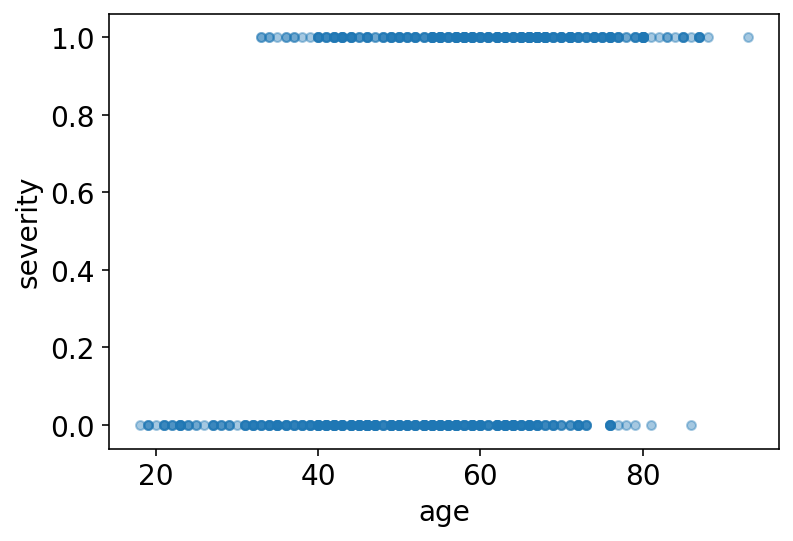

In [6]:
train.plot(x="age", y="severity", kind="scatter", alpha=0.4)
plt.show()

¿Podríamos usar una regresión lineal para predecir los datos? 

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

linreg = Pipeline([
    ("mean_imp", SimpleImputer()),
    ("linreg", LinearRegression())
])

xtrain, ytrain = train.age.values.reshape(-1,1), train.severity.values
linreg.fit(xtrain, ytrain)
train.plot(x="age", y="severity", kind="scatter", alpha=0.4)
plt.plot(xtrain, linreg.predict(xtrain), color="tab:orange");

NameError: name 'LinearRegression' is not defined

In [ ]:
print(f"La probabilidad de un tumor a edad 30 es: {linreg.predict([[30]])[0]:.2%}")
print(f"La probabilidad de un tumor a edad 50 es: {linreg.predict([[55]])[0]:.2%}")

In [ ]:
## --No existen probabilidades negativas o mayores a 1-- ##
print(f"La probabilidad de un tumor a edad 1 es: {linreg.predict([[1]])[0]:.2%}")
print(f"La probabilidad de un tumor 100 edad 120 es: {linreg.predict([[100]])[0]:.2%}")

La regresión lineal no es un buen modelo probabilístico. Nos gustaría encontrar una función que tome valores entre $0$ (nada probable) y $1$ (muy probable).

**La función sigmoidal:**

$$
    \sigma(x) = \frac{1}{1 + e^{-x}}
$$

In [ ]:
def sigmoid(x): return 1 / (1 + np.exp(-x))

# Si x es muy grande, sigma(x) se aproxima a 1
x = 100
print(f"sigmoid({x}) = {sigmoid(x):0.4f}")

# Si x es negativa, sigma(x) se aproxima a 0
x = -100
print(f"sigmoid({x}) = {sigmoid(x):0.4f}")

# Si x es 0,
x = 0
print(f"sigmoid({x}) = {sigmoid(x):0.4f}")


In [ ]:
xrange = np.linspace(-4, 4, 300)
plt.plot(xrange, sigmoid(xrange))
plt.title(r"$\sigma(x)$")
plt.yticks(np.arange(0, 1.1, 0.25))
plt.grid()

Para entrenar un modelo de machine learning usando $\sigma(x)$, consideramos el input $x$ como una combinación lineal entre parámetros y observaciones, es decir, queremos encontrar un vector ${\bf w}$ para un vector de observaciones ${\bf x}$ tal que

$$
\hat y_i = \sigma({\bf w}^T{\bf x})
=\frac{1}{1 + e^{-{\bf w}^T{\bf x}}}
$$

Necesitamos una medida de desempeño $P$

### Cross-Entropy Cost Function:
**Negativo de la log-verosimilitud para una variable aleatoria bernoulli parámetro $\sigma({\bf w}^T{\bf x})$**

$$
\begin{align}
    \mathcal{L}(y, \hat y) &= -\frac{1}{n}\sum_{i=1}^n y_i \log{\hat y_i} + (1 - y_i)\log{\left(1 - \hat y_i\right)}\\
                           &= -\frac{1}{n}\sum_{i=1}^n y_i \log{\sigma({\bf w}^Tx^{(i)})} + (1 - y_i)\log{\left(1 - \sigma({\bf w}^Tx^{(i)})\right)}
\end{align}    
$$

#### ¿Por qué tiene sentido?
supngamos que tenemos una sola observación $(x, y)$ y $\theta = [\theta_0, \theta_1]$ tal que $\hat y = \sigma(\theta_0 + \theta_1 x) = 1$, pero $y=0$

$$
\begin{align}
    \mathcal{L}(y, \hat y) &=-( y \log \hat y + (1 - y) \log (1 - \hat y))\\
    &= -\log(1 - \hat y)
\end{align}
$$

### Gradient Descent

No existe fóruma cerrada para encontrar los parámetros óptimos de una regresión logística, por lo que recurrimos a gradient descent para minimizar $\mathcal{L}(y, \hat y)$.

Se puede demostrar que

$$
    \frac{\partial}{\partial{\bf w}} = \frac{1}{N}\sum_{n=1}^N\left(\hat y^{(n)} - y^{(n)}\right){\bf x}^{(n)}
$$

Dónde $x_0^{(n)} = 1$ para $n = 1, \ldots, N$

<h2 style="color:crimson">Ejercicio</h2>

Por medio de gradient descent, encuentra el vector ${\bf w} \in \mathbb{R}^3$ de una regresión logística para los siguientes datos:

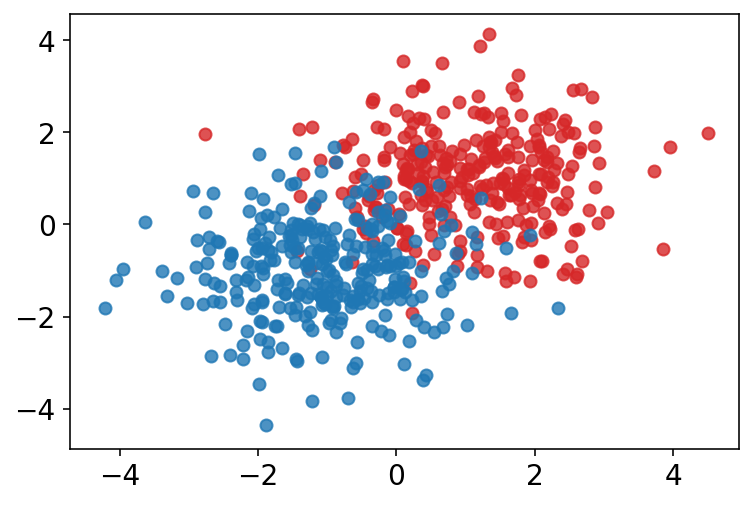

In [8]:
# Set seed to reproduce results
seed(1643)
nexamples = 300

# Agrupa filas: un termino de corrección (bias) y una matriz de
# 2 X nexamples de ruido gaussiano con media != 0
c1 = np.r_[np.ones((1, nexamples)), randn(2, nexamples) + 1]
c2 = np.r_[np.ones((1, nexamples)), randn(2, nexamples) - 1]

# Clasificamos nexamples del primer grupo (media = 1) y
# nexamples del segundo grupo (media - 1)
y = np.r_[np.ones(nexamples), np.zeros(nexamples)].reshape(-1, 1)
X = np.c_[c1, c2]

# Agrupamos las filas y columnas para permutar
# su orden 
data = np.r_[X, y.T].T
shuffle(data)
X = data[:, :3]
y = data.T[-1, :]

plt.scatter(*c1[1:,:], color="tab:red", alpha=0.8)
plt.scatter(*c2[1:,:], color="tab:blue", alpha=0.8);

<h2 style="color:crimson">Ejercicio</h2>

Considerando el siguiente training dataset, implementa una regresión logística usando `scikit-learn`.

```python
from sklearn.linear_model import LogisticRegression
xtrain = train.age.values.reshape(-1,1)
ytrain = train.severity.values
```

Observa la exacitud del modelo usando
```python
logreg.score(xtrain, ytrain)
```

¿Qué te dice el resultado?

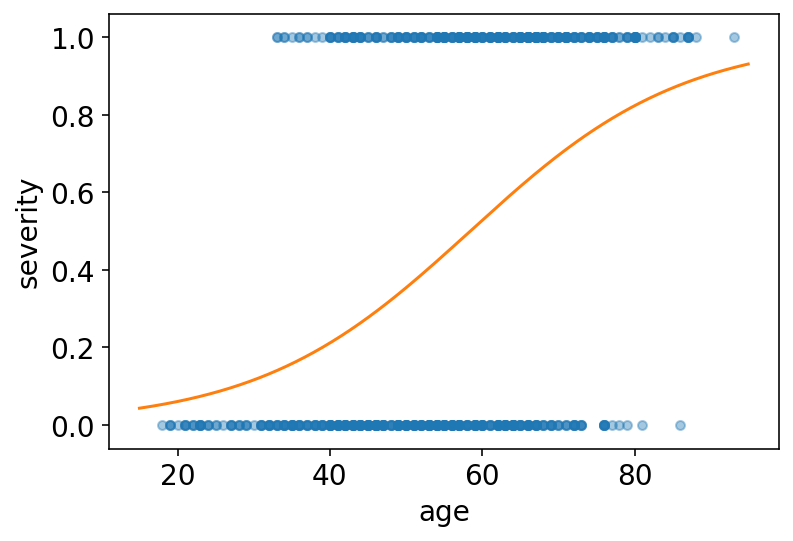

In [9]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ("mean_imp", SimpleImputer()),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

xtrain, ytrain = train.age.values.reshape(-1,1), train.severity.values
logreg.fit(xtrain, ytrain)
train.plot(x="age", y="severity", kind="scatter", alpha=0.4)
xrange = np.arange(15, 95, 0.1)
plt.plot(xrange, logreg.predict_proba(xrange.reshape(-1,1))[:,1],
        color="tab:orange");

In [18]:
from sklearn.model_selection import cross_validate
cvscore = cross_validate(logreg, xtrain, ytrain, cv=8, scoring="precision")

# Estimación: intervalo de medida *accuracy* final
cvscore["test_score"].mean() + np.array([-1, 1]) * cvscore["test_score"].std()

array([0.60483319, 0.68890382])

## Error Analysis

### Confusion Matrix
![conf_matrix](./images/cmatrix.png)

| Ref            | Actual    | Predicción |
|----------------|-----------|------------|
| **True Positive** (TP) | Verdadero | Verdadero  |
| **True Negative** (TN) | Falso     | Falso      |
| **False Positive** (FP)| Falso     | Verdadero  |
| **False Negative** (FN)| Verdadero | Falso      |

### Metricas para un clasificador binario

$$
    \mbox{Precision} = \frac{TP}{TP + FP}
$$

$$
    \mbox{Recall} = \frac{TP}{TP + FN}
$$

* *Precision* considera todos los valores sobre los cuales nuestro modelo clasificó como positivos ($TP + FP$)
* *Recall* considera todos los valores que son realmente positivos ($TP + FN$)

### Precision - Recall Tradeoff
**¿Qué metrica usar?**
* Usamos *precision* si no interesa maximizar la *pureza* de nuestras predicciones a costa de sacrificar el número de predicciones echas como verdaderas, i.e., menos $FP$ a cambio de más $FN$.
* Usamos *recall* si nos intersa maximizar el número de observaciones positivas clasificadas como positivas a costa de clasificar incorrectamente observaciones negativas como positivas, i.e., más $FP$ a cambio de menos $FN$

----

$$
    \max \text{precision} \implies \downarrow FP \ \wedge \uparrow FN
$$

$$
    \max \text{recall} \implies \uparrow FP \ \wedge \downarrow FN
$$


### Variando el *threshold*

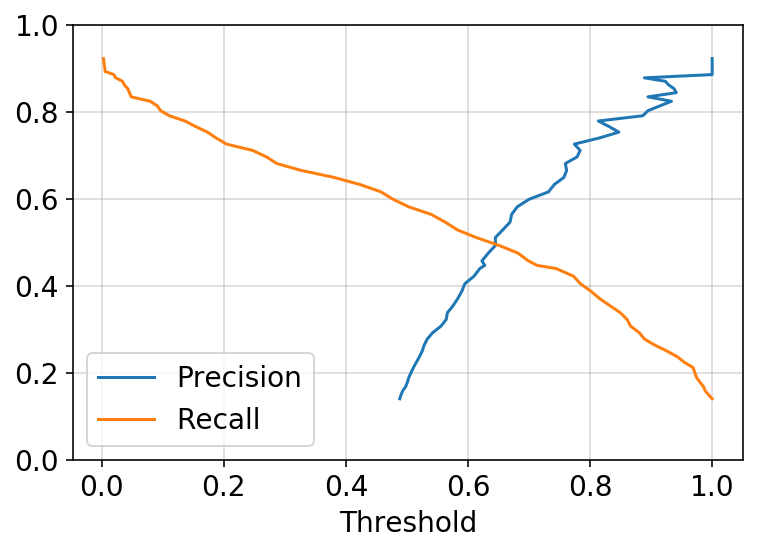

In [11]:
from sklearn.metrics import precision_recall_curve

logreg = Pipeline([
    ("mean_imp", SimpleImputer()),
    ("log_reg", LogisticRegression(solver="lbfgs"))
])

xtrain, ytrain = train.age.values.reshape(-1,1), train.severity.values
logreg.fit(xtrain, ytrain)


precision, recall, threshold = precision_recall_curve(ytrain, logreg.predict_proba(xtrain)[:, 1])
plt.plot(precision[:-1], threshold, label="Precision")
plt.plot(recall[:-1], threshold, label="Recall")
plt.xlabel("Threshold")
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.legend()
plt.grid(alpha=0.5)

<h2 style="color:crimson">Ejercicio</h2>

1. Supón queremos entrenar una regresión logística para detectar transacciones fradulentas con tarjetas de crédito, ¿nos interesaría obtener un *recall* o *precision* más alto? ¿por qué?
2. Supón queremos entrenar una regresión logística para detectar películas aptas para niños, ¿nos interesaría obtener el *recall* o *precision*? ¿por qué?
3. Considerando nuestro problema inicial, detectar tumores benignos, ¿nos interesaría más enforcarnos en *precision* o *recall*? ¿por qué?

### Confusion Matrix en `scikit-learn`

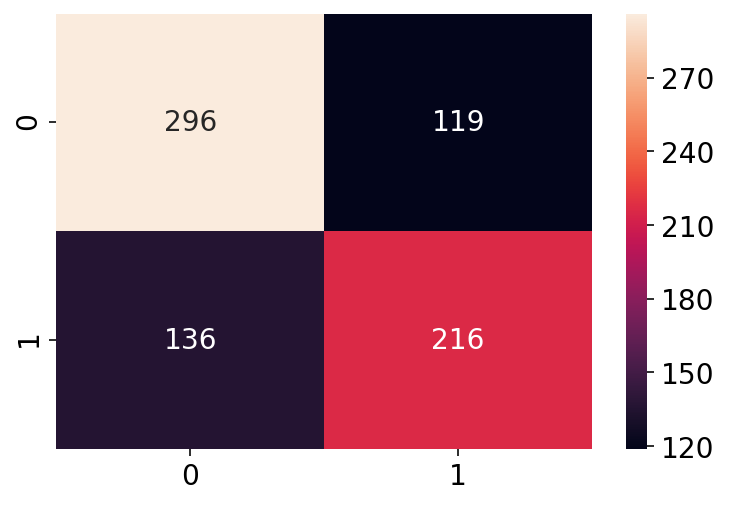

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cmat = confusion_matrix(ytrain, logreg.predict(xtrain))
sns.heatmap(cmat, annot=True, fmt=",")

<h2 style="color:crimson">Ejercicio</h2>

Considerando el *confusion matrix* `cmat`, cálcula las metricas: *precision* y *recall*
```python
>>> cmat
array([[296, 119],
       [137, 216]])
```

#### Métricas en `scikit-learn`

In [13]:
from sklearn.metrics import precision_score, recall_score, accuracy_score
ypreds = logreg.predict(xtrain)
print(f"Precision: {precision_score(ytrain, ypreds):0.3%}")
print(f"Recall: {recall_score(ytrain, ypreds):>10.3%}")
print(f"Accuracy: {accuracy_score(ytrain, ypreds):>8.3%}")

Precision: 64.478%
Recall:    61.364%
Accuracy:  66.754%


### One-Hot Encoders
**¿Podemos mejorar nuestras métricas? Considerando una segunda variable**

Podríamos incluír en nuestra hipótesis que el *margen* de un tumor es importante para clasificar si es benigno o no.

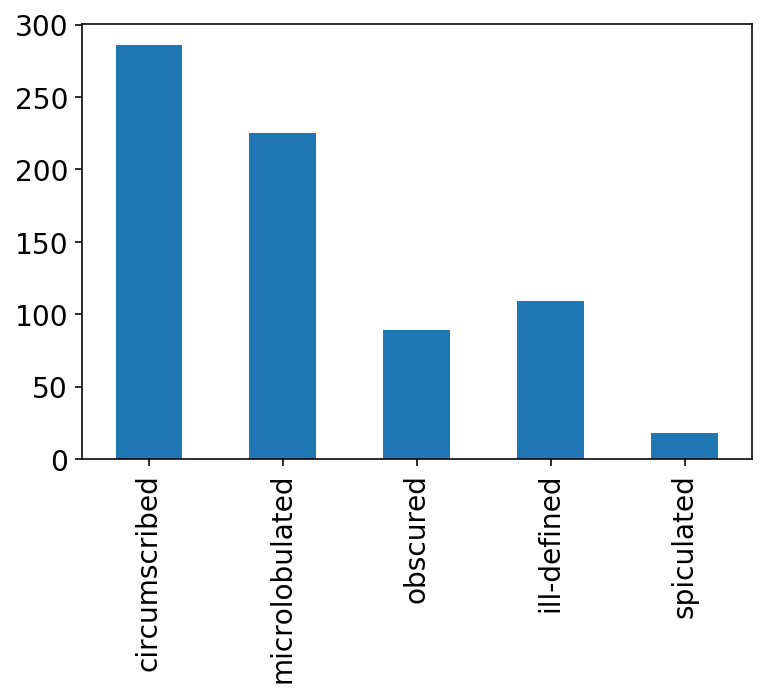

In [20]:
mass_cat = range(5)
mass_lab = ['circumscribed', 'microlobulated', 'obscured', 'ill-defined', 'spiculated']
train["margin"].value_counts(sort=False).plot(kind="bar", color="tab:blue")
plt.xticks(mass_cat, mass_lab);

In [58]:
from sklearn.tree import DecisionTreeClassifier

In [61]:
xtrain, ytrain = train[["age", "margin"]].values, train.severity
logreg = Pipeline([
    # Valores con NaN los remplazamos con la media
    ("mean_imp", SimpleImputer()), 
    ("log_reg", DecisionTreeClassifier())
])

cv = cross_validate(logreg, xtrain, ytrain, cv=10, scoring="precision")
print(f"Cross validation score: {cv['test_score'].mean():0.3%}")

Cross validation score: 71.902%


In [24]:
cv['test_score'].mean() + np.array([-1, 1]) * cv['test_score'].std()

array([0.66346944, 0.79824741])

En este ejemplo, vemos que al agregar un nuevo feature, nuestro *accuracy* promedio se eleva a un *76%*. A pesar de esta mejora en el modelo, **la representación de los valores hacia el modelo es importante para una mejor clasificación.**

la variable *margin* es categorica, lo cual implica que sus valores [1, 2, 3, 4, 5], no representan en realidad ningun factor numérico de rango o importancia. Que *microbulated* esté más cerca de *obsured* que *spiculated* no implica realmente nada.

Al trabajar con una variable categorica, para otorgar una mejor *representación* al modelo, tranformamos la variable usando el método *One Hot Encoder*

Consideremos la siguiente columna de variables categóricas:

|obs| feat |
|--|-----| 
|o1|A |
|o2|B |
|o3|C |
|o4|C |
|o5|B |

Podemos modificar esta columna para poder ingresarla a nuestro modelo creando 3 nuevos *features*, uno para cada cada categoría. Evidentemente, una observación solo tendrá una clase asignada, es decir, un solo uno seguido de una fila de ceros. En nuestro ejemplo anterior, esto quedaría como sigue:

|obs|feat_A|feat_B|feat_C|
|--|-----|-----|-----|
|o1|1|0|0|
|o2|0|1|0|
|o3|0|0|1|
|o4|0|0|1|
|o5|0|1|0|

De esta manera, ya podemos entrenar nuestro modelo usando variables categóricas.

Para lograr lo anterior con `scikit-learn`, podemos usar el *transformer* `OneHotEncoder` dentro de `preprocessing`

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

xtrain, ytrain = train[["age", "margin"]], train[["severity"]]

In [39]:
margin_pipe.fit_transform(train[["margin"]])

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]])

In [43]:
margin_pipe = Pipeline([
    ("imputer", SimpleImputer()),
    ("ohe", OneHotEncoder(categories="auto", sparse=False))
])

# Seleccionamos las transformaciones y columnas a ocupar para el modelo
cX = ColumnTransformer([
    ("clean_margin", margin_pipe, ["margin"]),
    ("age_selector", SimpleImputer(), ["age"])
])

logreg = Pipeline([
    ("cX", cX),
    ("model", LogisticRegression(solver="lbfgs", max_iter=500))
])

cv = cross_validate(logreg, train, train["severity"], cv=10)
print(f"Cross validation score: {cv['test_score'].mean():0.3%}")

Cross validation score: 79.793%


In [31]:
cv['test_score'].mean() + np.array([-1, 1]) * cv['test_score'].std()

array([0.72314182, 0.82320131])

<h2 style="color:crimson">Ejercicio</h2>

Consideremos una tercera variable para nuestro modelo. Ocupando `["age", "margin", "shape"]`, modela la probabilidad de un tumor beningno. Transorma `"margin"` y `"shape"` usado `OneHotEncoder`

## Todo Junto

In [53]:
train.dtypes[train.dtypes == np.float64].index

Index(['bi_rads', 'age', 'shape', 'margin', 'density'], dtype='object')

In [55]:
train.dtypes[train.dtypes == np.int].index

Index(['severity'], dtype='object')

In [46]:
input_encode = Pipeline([
    ("imputer", SimpleImputer()),
    ("ohe", OneHotEncoder(categories="auto"))
])

cX = ColumnTransformer([
    ("categoricals", input_encode, ["margin", "shape", "bi_rads", "density"]),
    ("continuous", SimpleImputer(), ["age"])
])

logreg = Pipeline([
    ("cX", cX),
    ("model", LogisticRegression(solver="lbfgs", max_iter=500))
])


cv = cross_validate(logreg, train, train["severity"], cv=10)
print(f"Cross validation score: {cv['test_score'].mean():0.3%}")


Cross validation score: 81.869%


In [25]:
cv['test_score'].mean() + np.array([-1, 1]) * cv['test_score'].std()

array([0.78386123, 0.85869796])

<h2 style="color:crimson">Ejercicio</h2>

Con el modelo final, prueba el accuracy sobre el *test set*:

1. Entrena el modelo usando `logreg.fit(xtrain, ytrain)`
2. Crea `xtest`, `ytest`,
```python
xtest = test[["age", "margin", "shape", "density", "bi_rads"]].values
ytest = test.severity
```
3. Encuentra el resultado final del modelo 